# Customer churn analysis

#### In previous demo (https://github.com/sfc-gh-pjain/telco) we have seen how you can build an end to end data pipeline using snowflake features like snowpipe, schema detection, snowpark API, Java UDF and serverless tasks.

This demo is continuation of the telco pipeline where we are tasked to find out the customer churn using the data


In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark import functions as F
from snowflake.snowpark.types import *
from snowflake.snowpark.functions import udf

import pandas as pd

from sklearn import linear_model

import matplotlib.pyplot as plt

%matplotlib inline
import datetime as dt
import numpy as np
import seaborn as sns

#Snowflake connection info
from config import snowfalke_conn_prop

In [2]:
from snowflake.snowpark import version
print(version.VERSION)

session = Session.builder.configs(snowfalke_conn_prop).create()
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

(0, 2, 0, None)
[Row(CURRENT_WAREHOUSE()='LAB_L_WH', CURRENT_DATABASE()='DEMO', CURRENT_SCHEMA()='TELCO')]


In [3]:
%%time
# please visit https://github.com/sfc-gh-pjain/telco to get the dataset

# CREATE OR REPLACE VIEW TRAIN_DATASET
# AS
# SELECT D.CUSTOMERID, D.GENDER,D.SENIORCITIZEN,D.PARTNER,D.DEPENDENTS,
# S.PHONESERVICE, S.MULTIPLELINES, S.INTERNETSERVICE,S.ONLINESECURITY,
# S.ONLINEBACKUP, S.DEVICEPROTECTION, S.TECHSUPPORT, S.STREAMINGTV,
# S.STREAMINGMOVIES ,S.CONTRACT, S.PAPERLESSBILLING, S.PAYMENTMETHOD, 
# S.TENUREMONTHS, S.MONTHLYCHARGES, S.TOTALCHARGES,
# S.CHURNVALUE

# FROM DEMOGRAPHICS D LEFT OUTER JOIN 
# SERVICES S ON S.CUSTOMERID = D.CUSTOMERID
#  ;

raw = session.table('TRAIN_DATASET').sample(n = 20000)
data = raw.toPandas()

CPU times: user 1.09 s, sys: 28 ms, total: 1.12 s
Wall time: 7.78 s


# Machine Learning Pipeline - Data Analysis

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline. 

We will discuss:

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

In [4]:
# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)
data.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,3454-lrkoX,Female,False,True,True,True,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,False,Electronic check,63,19.35,1263.85,0
1,9832-GJADy,Female,False,False,False,True,No,DSL,No,No,No,Yes,Yes,No,Month-to-month,True,Bank transfer (automatic),9,59.50,530.05,0
2,1652-ey3NF,Female,False,False,False,True,Yes,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,False,Credit card (automatic),35,85.30,2917.50,1
3,4857-U7Rty,Female,False,False,False,True,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,False,Bank transfer (automatic),51,107.45,5680.90,0
4,3137-LsrgC,Male,False,False,True,False,No phone service,DSL,Yes,Yes,Yes,No,No,No,Month-to-month,True,Electronic check,43,40.45,1912.85,0


In [5]:
print(data.shape)

(20000, 21)


## Analysis

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Discrete
    - Continuous
    - Distributions
    - Transformations

5. Categorical variables
    - Cardinality
    - Rare Labels
    - Special mappings
    
6. Additional Reading Resources

## Target

Let's begin by exploring the target distribution.

In [8]:
# We'll print the target variable, target names, and frequency of each unique value:

(unique, counts) = np.unique(data['CHURNVALUE'], return_counts=True)

print('Unique values of target variable', unique)
print('Counts of target variable', counts)

Unique values of target variable [0 1]
Counts of target variable [13541  6459]


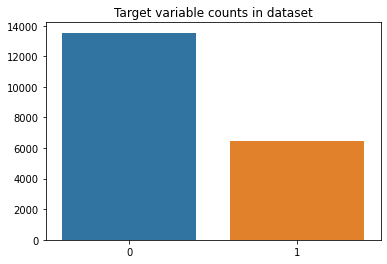

In [9]:
sns.barplot(x=unique, y=counts)
plt.title('Target variable counts in dataset')
plt.show()

## Step 1: Define explonatory variables and target variable

In [10]:
data.head()

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,TENUREMONTHS,MONTHLYCHARGES,TOTALCHARGES,CHURNVALUE
0,3454-lrkoX,Female,False,True,True,True,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,False,Electronic check,63,19.35,1263.85,0
1,9832-GJADy,Female,False,False,False,True,No,DSL,No,No,No,Yes,Yes,No,Month-to-month,True,Bank transfer (automatic),9,59.50,530.05,0
2,1652-ey3NF,Female,False,False,False,True,Yes,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,False,Credit card (automatic),35,85.30,2917.50,1
3,4857-U7Rty,Female,False,False,False,True,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,False,Bank transfer (automatic),51,107.45,5680.90,0
4,3137-LsrgC,Male,False,False,True,False,No phone service,DSL,Yes,Yes,Yes,No,No,No,Month-to-month,True,Electronic check,43,40.45,1912.85,0


In [11]:
# let's identify the categorical variables
# we will capture those of type *object*
cat_vars = [var for var in data.columns if ((data[var].dtype == 'O') or (data[var].dtype=="bool"))]

# Remove any misinterpreted objects like CutomerID
cat_vars.pop(0)

print(cat_vars)

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']


16

In [12]:
# now let's identify the numerical variables
num_vars = [var for var in data.columns if var not in cat_vars and var != 'CHURNVALUE' and var != 'CUSTOMERID']

# number of numerical variables
print(num_vars)

['TENUREMONTHS', 'MONTHLYCHARGES', 'TOTALCHARGES']


3

   TENUREMONTHS  MONTHLYCHARGES  TOTALCHARGES
0            63           19.35       1263.85
1             9           59.50        530.05
2            35           85.30       2917.50
3            51          107.45       5680.90
4            43           40.45       1912.85


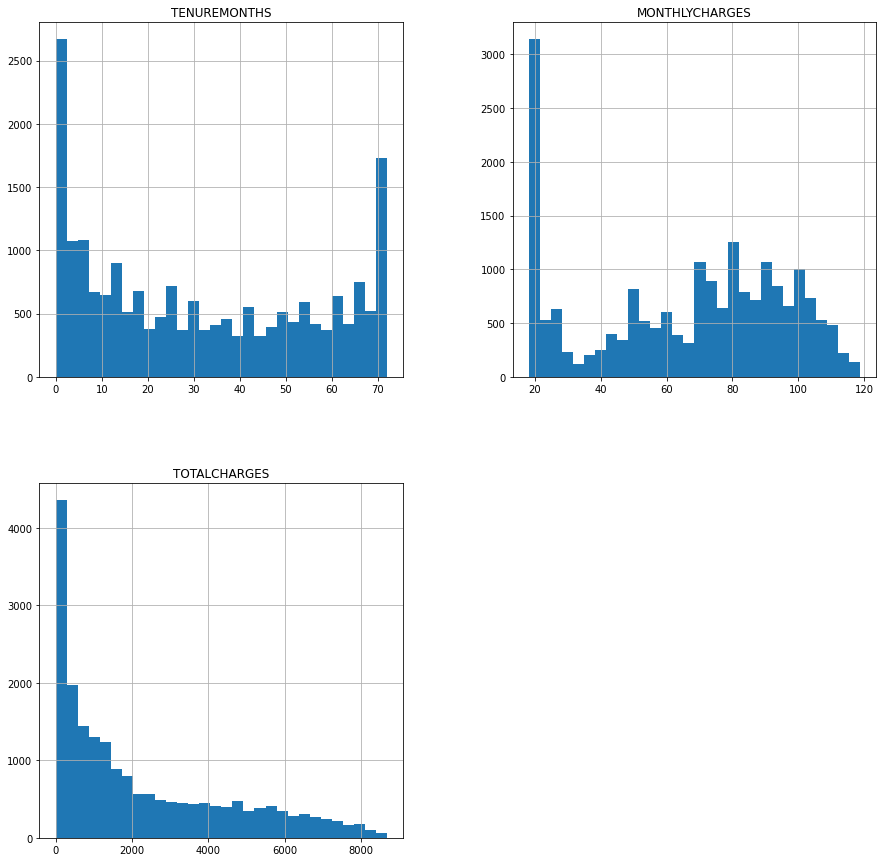

In [13]:
# lets plot histograms for all continuous variables
print(data[num_vars].head())
data[num_vars].hist(bins=30, figsize=(15,15))
plt.show()

# Missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [14]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

Series([], dtype: float64)

# Numerical variables

Let's go ahead and find out what numerical variables we have in the dataset

In [30]:
print('Number of numerical variables: ', len(num_vars))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_df = data[num_vars]
scaler.fit(num_df,y=None)

# visualise the numerical variables
print(scaler.transform(num_df))

Number of numerical variables:  3
[[0.875      0.01094527 0.14552436]
 [0.125      0.41044776 0.06103192]
 [0.48611111 0.66716418 0.33593174]
 ...
 [1.         0.90995025 0.93603768]
 [0.43055556 0.63134328 0.29346099]
 [0.15277778 0.47860697 0.08529845]]


# Categorical variables

Let's go ahead and analyse the categorical variables present in the dataset.

In [16]:
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  16


In [17]:
# let's visualise the values of the categorical variables
data[cat_vars].head()

,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD
0,Female,False,True,True,True,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,False,Electronic check
1,Female,False,False,False,True,No,DSL,No,No,No,Yes,Yes,No,Month-to-month,True,Bank transfer (automatic)
2,Female,False,False,False,True,Yes,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,False,Credit card (automatic)
3,Female,False,False,False,True,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,One year,False,Bank transfer (automatic)
4,Male,False,False,True,False,No phone service,DSL,Yes,Yes,Yes,No,No,No,Month-to-month,True,Electronic check


## Number of labels: cardinality

Let's evaluate how many different categories are present in each of the variables.

<AxesSubplot:>

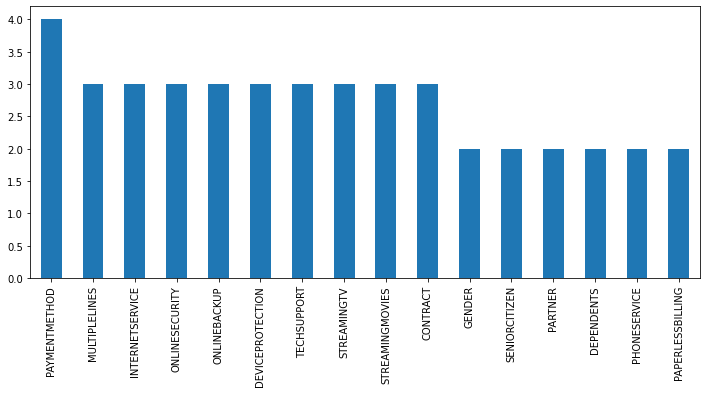

In [18]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

## Rare labels:

Let's go ahead and investigate now if there are labels that are present only in a small number of customers:

In [19]:
print(cat_vars)
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)['CHURNVALUE'].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data, var, 0.01))
    print()

['GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD']
Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)

Series([], Name: CHURNVALUE, dtype: float64)



### So all the cat variables are distributed well

In [20]:
data[cat_vars].shape, data[num_vars].shape, data['CHURNVALUE'].shape

final_cols = cat_vars + num_vars + ['CHURNVALUE']
final_cols

['GENDER',
 'SENIORCITIZEN',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'TENUREMONTHS',
 'MONTHLYCHARGES',
 'TOTALCHARGES',
 'CHURNVALUE']

In [21]:
%%time
snowpark_test_df = session.write_pandas(data[final_cols], 'TELCO_TRAIN', auto_create_table=True)

CPU times: user 309 ms, sys: 0 ns, total: 309 ms
Wall time: 6.68 s


# Off to training a model and deplyment
